# Experiment 3: Using averaged photos, using a commercial, black-box model

### Training

We first import the required libraries, and set up the model, dataloaders and optimizer for training. This step is almost wholly identical to the previous two experiments, except that we initialize the Generator with an input dimension of 1024. The training data is a folder containing the averaged images, and their embedding vectors, precomputed and saved from the outputs produced by Clarifai's Python API 

In [1]:
import torch
from torch.utils.data import DataLoader
from torch import nn, optim

from model import Generator
from dataset import EmbedImagePairs
from train import train, test, synthesize

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
model = Generator(1024).to(device)

trn_dataloader = DataLoader(EmbedImagePairs('/floyd/input/data/1024dim/train_avg', size=64, n_hidden=1024), batch_size=200, shuffle=True)
dataloader_dict = {'train': trn_dataloader}

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters())

We create a folder to store all the outputs of this training run

In [4]:
# !rm -r "models/pytorch/1024"
!mkdir -p "models/pytorch/1024"

We train the model for 150 epochs, performing a validation run every 5 epochs. No point in calling dlib here since we're not using its models. We don't run validation here either, both for the fact it'd require a new implementation, and would require usage of 113 Clarifai API calls everytime we perform validation.  

In [5]:
num_epochs=150

train(model, dataloader_dict, criterion, optimizer, device, out_name='models/pytorch/1024/model', num_epochs=num_epochs)

  7%|▋         | 10/150 [00:19<04:42,  2.02s/it]

saving at epoch 10


 13%|█▎        | 20/150 [00:40<04:27,  2.06s/it]

saving at epoch 20


 20%|██        | 30/150 [01:00<04:06,  2.06s/it]

saving at epoch 30


 27%|██▋       | 40/150 [01:20<03:48,  2.07s/it]

saving at epoch 40


 33%|███▎      | 50/150 [01:41<03:28,  2.08s/it]

saving at epoch 50


 40%|████      | 60/150 [02:01<03:05,  2.06s/it]

saving at epoch 60


 47%|████▋     | 70/150 [02:21<02:43,  2.04s/it]

saving at epoch 70


 53%|█████▎    | 80/150 [02:42<02:24,  2.07s/it]

saving at epoch 80


 60%|██████    | 90/150 [03:02<02:05,  2.10s/it]

saving at epoch 90


 67%|██████▋   | 100/150 [03:22<01:42,  2.06s/it]

saving at epoch 100


 73%|███████▎  | 110/150 [03:42<01:21,  2.03s/it]

saving at epoch 110


 80%|████████  | 120/150 [04:02<01:00,  2.03s/it]

saving at epoch 120


 87%|████████▋ | 130/150 [04:23<00:41,  2.06s/it]

saving at epoch 130


 93%|█████████▎| 140/150 [04:43<00:20,  2.09s/it]

saving at epoch 140


100%|██████████| 150/150 [05:04<00:00,  2.06s/it]

saving at epoch 150
saving at epoch 150


### Evaluating

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import percentileofscore

In [7]:
trn_losses = np.load('models/pytorch/1024/modeltrn_losses.npy')

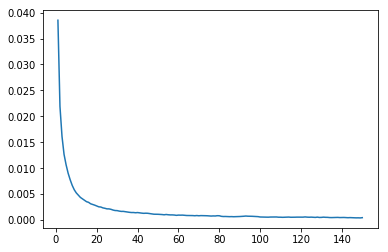

In [8]:
sns.lineplot(x=range(1, num_epochs+1), y=trn_losses)

We just load in the parameters from the last epoch

In [9]:
data = torch.load(f'models/pytorch/1024/model_{num_epochs}.pth')

model = Generator(1024).to(device)
model.eval()

model.load_state_dict(data["model_state_dict"])

Prepare a dataloader for the test embeddings, get their synthesized images, and save them to disk

In [10]:
test_dataloader = DataLoader(EmbedImagePairs('/floyd/input/data/1024dim/test', size=64, n_hidden=128, train=False), batch_size=100)

In [11]:
# !rm -r "models/pytorch/1024/test_synth"
!mkdir -p "models/pytorch/1024/test_synth"

test_images, names = synthesize(model, test_dataloader, device)

for image, name in zip(test_images, names):
    plt.imsave("models/pytorch/1024/test_synth/" + (name.split("/")[-1]).replace('.npy', '.jpg'), image)

In [12]:
!pip install clarifai

menpo 0.8.1 has requirement matplotlib<2.0,>=1.4, but you'll have matplotlib 3.0.2 which is incompatible.
menpo 0.8.1 has requirement pillow<5.0,>=3.0, but you'll have pillow 5.4.0 which is incompatible.
menpo 0.8.1 has requirement scipy<1.0,>=0.16, but you'll have scipy 1.2.0 which is incompatible.
You are using pip version 10.0.1, however version 19.0 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


Get an embedding from the cloud, for each synthesized image produced from the test set

In [13]:
import glob 

from clarifai.rest import ClarifaiApp
from tqdm import tqdm

app = ClarifaiApp(api_key="") # pass in your API key here
clarifai_model = app.models.get("d02b4508df58432fbb84e800597b8959")

for fname in tqdm(glob.glob('models/pytorch/1024/test_synth/*.jpg')):
    annot = clarifai_model.predict_by_filename(fname)
    embed = np.array(annot["outputs"][0]["data"]["regions"][0]["data"]["embeddings"][0]["vector"])
    
    np.save(fname.replace('.jpg', '.npy'), embed)

100%|██████████| 108/108 [00:26<00:00,  3.94it/s]


Load in all the saved true vectors of the test set, and their synthesized counterparts

In [14]:
true_vecs = sorted(glob.glob('models/pytorch/1024/test_synth/*.npy'))
synth_vecs = sorted(glob.glob('/floyd/input/data/1024dim/test/*.npy'))

We need a function to shuffle the vectors to compare (true-synth) and (true-random) vectors. In order to ensure no vectors remain in their original location after shuffling, we need to obtain a derangement

In [19]:
# from https://stackoverflow.com/questions/26554211/numpy-shuffle-with-constraint

def random_derangement(n):
    while True:
        v = np.arange(n)
        for j in np.arange(n - 1, -1, -1):
            p = np.random.randint(0, j+1)
            if v[p] == j:
                break
            else:
                v[j], v[p] = v[p], v[j]
        else:
            if v[0] != 0:
                return v

We produce the true distances, as well as a set of distances between random pairs, and plot their histograms

In [20]:
test_dists = []

for true, synth in zip(true_vecs, synth_vecs):
    true = np.load(true)
    synth = np.load(synth)
    
    dist = np.linalg.norm(true - synth)
    test_dists += [dist]
    
random_dists = []

synth_shuffled = np.array(synth_vecs)[random_derangement(len(synth_vecs))]

for true, synth in zip(true_vecs, synth_shuffled):
    true = np.load(true)
    synth = np.load(synth)
    
    dist = np.linalg.norm(true - synth)
    random_dists += [dist]

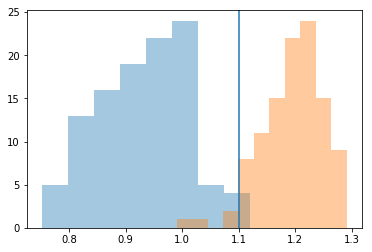

In [21]:
sns.distplot(test_dists, kde=False)
sns.distplot(random_dists, kde=False)
plt.axvline(x=1.1)
plt.show()

In [22]:
thresholds = [0.9, 0.95, 1.0, 1.05, 1.1]

for threshold in thresholds:
    pct = percentileofscore(test_dists, threshold)
    print(f"At threshold {threshold}, percent of synthesized images classified as same person", pct)

mean = np.mean(test_dists)
print("Average distance (test):", mean)

At threshold 0.9, percent of synthesized images classified as same person 34.25925925925926
At threshold 0.95, percent of synthesized images classified as same person 52.77777777777778
At threshold 1.0, percent of synthesized images classified as same person 80.55555555555556
At threshold 1.05, percent of synthesized images classified as same person 94.44444444444444
At threshold 1.1, percent of synthesized images classified as same person 98.14814814814815
Average distance (test): 0.9323047921884644


We prepare a dataloader for the visualization set, synthesize their images and plot them out

In [23]:
vis_dataloader = DataLoader(EmbedImagePairs('/floyd/input/data/1024dim/vis', size=64, n_hidden=1024, train=False), batch_size=8)

In [24]:
vis_images, names = synthesize(model, vis_dataloader, device)

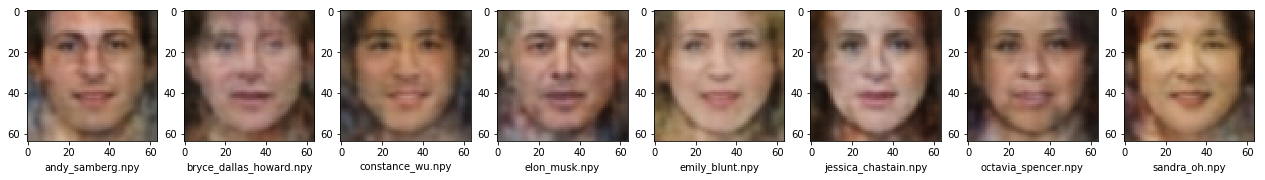

In [25]:
fig, ax = plt.subplots(1,len(vis_images))
fig.set_size_inches(22, 3)

for i in range(len(vis_images)):
    image, name = vis_images[i], names[i]
    ax[i].imshow(image)
    ax[i].set_xlabel(name.split("/")[-1])